In [56]:
import pandas as pd
import numpy as np
import sys
from itertools import groupby
from IPython.display import display
import os

# Descripcion de los datos:
# head movies.csv:
"""
    movieId,title,genres
    1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
    2,Jumanji (1995),Adventure|Children|Fantasy
    3,Grumpier Old Men (1995),Comedy|Romance
    4,Waiting to Exhale (1995),Comedy|Drama|Romance
    5,Father of the Bride Part II (1995),Comedy
    6,Heat (1995),Action|Crime|Thriller
    7,Sabrina (1995),Comedy|Romance
    8,Tom and Huck (1995),Adventure|Children
    9,Sudden Death (1995),Action
"""

# head ratings.csv
"""
    userId,movieId,rating,timestamp
    1,2,3.5,1112486027
    1,29,3.5,1112484676
    1,32,3.5,1112484819
    1,47,3.5,1112484727
    1,50,3.5,1112484580
    1,112,3.5,1094785740
    1,151,4.0,1094785734
    1,223,4.0,1112485573
    1,253,4.0,1112484940
"""

data_folder = '/media/hudson/Elements/data/DiploDatos-aprendizaje-no-supervizado/ml-20m'
movies_path = os.path.join(data_folder, 'movies.csv')
ratings_path = os.path.join(data_folder, 'ratings.csv')

def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [71]:
movies = pd.read_csv(movies_path)
print('movies -- dimensions: {0};   size: {1}'.format(movies.shape, size(movies)))
display(movies.head())

movies -- dimensions: (27278, 3);   size: 4.50 MB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,title,genres,splitted_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


Drama                 13344
Comedy                 8374
Thriller               4178
Romance                4127
Action                 3520
Crime                  2939
Horror                 2611
Documentary            2471
Adventure              2329
Sci-Fi                 1743
Mystery                1514
Fantasy                1412
War                    1194
Children               1139
Musical                1036
Animation              1027
Western                 676
Film-Noir               330
(no genres listed)      246
IMAX                    196
dtype: int64

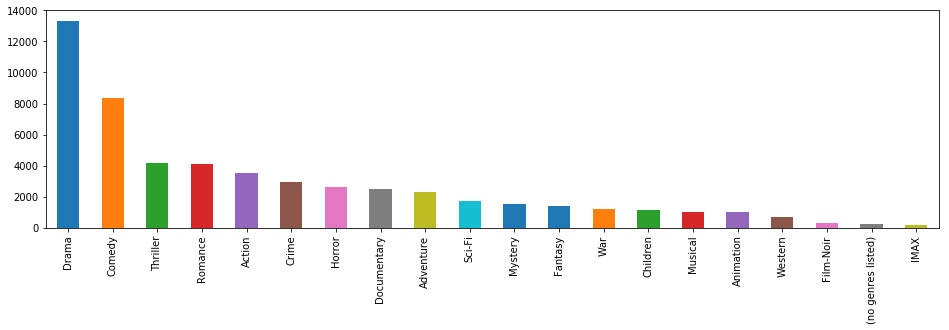

In [90]:
import matplotlib.pyplot as plt
movies['splitted_genres'] = movies['genres'].str.split('|', n=0, expand=False)
display(movies.head())
# generos = movies['splitted_genres'].unique()
count_by_genre = movies['splitted_genres'].apply(pd.Series).stack().value_counts()
display(count_by_genre)
count_by_genre.plot.bar(figsize=(16, 4))

In [97]:
# Obtener los dummies sobre un campo que tiene listas dentro
# https://stackoverflow.com/questions/47026585/unhashable-type-list-error-with-get-dumies
# pd.get_dummies(df.categories.apply(pd.Series).stack()).sum(level=0)

dummy_genres = pd.get_dummies(movies['splitted_genres'].apply(pd.Series).stack()).sum(level=0)
movies_with_dummies_genres = pd.concat([movies, dummy_genres], axis=1)
# se quitan las dos ultimas categorías que tiene pocas películas
movies_cleaned = movies_with_dummies_genres.drop(columns=['genres', 'splitted_genres', 'IMAX','(no genres listed)'])
display(movies_cleaned.head())

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [86]:
ratings = pd.read_csv(ratings_path, usecols = ['userId', 'movieId', 'rating'])
print('ratings -- dimensions: {0};   size: {1}'.format(ratings.shape, size(ratings)))
display(ratings.head())

ratings -- dimensions: (20000263, 3);   size: 480.01 MB


,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


rating
0.5     239125
1.0     680732
1.5     279252
2.0    1430997
2.5     883398
3.0    4291193
3.5    2200156
4.0    5561926
4.5    1534824
5.0    2898660
dtype: int64

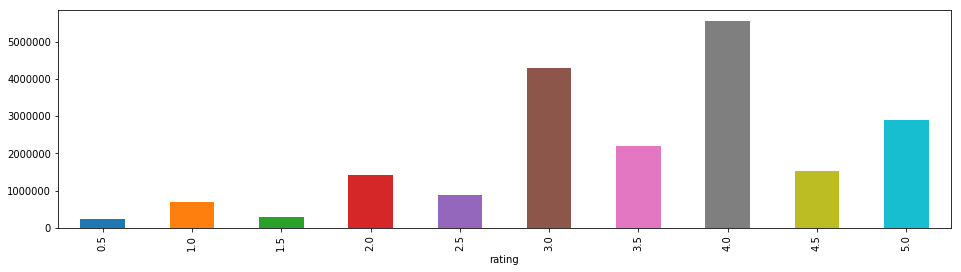

In [87]:
# Cuantos ratings hay con cada puntuacion?
# No me interesan los bajos. Entiendo que "comprar" el item es darle un buen rating
count_by_rank = ratings.groupby('rating').size()
display(count_by_rank)
count_by_rank.plot.bar(figsize=(16, 4))

In [21]:
# voy a tomar solo los ratings > a lo que defino
min_rating_to_count = 5
ratings_good = ratings[ratings['rating'] >= min_rating_to_count]
print('ratings_good -- dimensions: {0};   size: {1}'.format(ratings_good.shape, size(ratings_good)))
display(ratings_good.head())

rating
0.5     239125
1.0     680732
1.5     279252
2.0    1430997
2.5     883398
3.0    4291193
3.5    2200156
4.0    5561926
4.5    1534824
5.0    2898660
dtype: int64
ratings_good -- dimensions: (2898660, 3);   size: 92.76 MB


,userId,movieId,rating
131,1,4993,5.0
142,1,5952,5.0
158,1,7153,5.0
170,1,8507,5.0
176,2,62,5.0


In [100]:
# tomo al "userid" como el identificador de transaccion.
# Interpreto que lo cada uusario vio y valoro positivamente es un "compra"
# Quitar el rating que no es necesario
ratings_cleaned = ratings.drop(columns=['rating'])

# identificar las transacciones (IDUSUARIO = [ID_PELI_1, ID_PELI_n, ID_PELI_m, ...])
transactions = ratings_cleaned.groupby('userId')['movieId'].apply(list)
print('------------- Transacciones (solo algunas) -----------------')
print(transactions[:20])

------------- Transacciones (solo algunas) -----------------
userId
1     [2, 29, 32, 47, 50, 112, 151, 223, 253, 260, 2...
2     [3, 62, 70, 110, 242, 260, 266, 469, 480, 541,...
3     [1, 24, 32, 50, 160, 173, 175, 196, 223, 260, ...
4     [6, 10, 19, 32, 165, 329, 350, 356, 367, 368, ...
5     [2, 11, 17, 60, 62, 104, 110, 140, 141, 150, 2...
6     [1, 3, 7, 17, 52, 62, 135, 140, 141, 260, 494,...
7     [3, 7, 11, 15, 16, 17, 24, 105, 122, 151, 252,...
8     [1, 3, 6, 10, 19, 21, 39, 47, 48, 110, 150, 15...
9     [356, 858, 1219, 1911, 1923, 1997, 2279, 2605,...
10    [1, 11, 25, 260, 356, 527, 858, 912, 969, 1094...
11    [1, 10, 19, 32, 39, 65, 110, 145, 150, 153, 15...
12    [1, 3, 5, 6, 7, 17, 32, 34, 36, 95, 104, 110, ...
13    [1, 2, 10, 11, 19, 32, 34, 39, 47, 95, 110, 15...
14    [1, 7, 17, 34, 62, 150, 252, 260, 277, 314, 31...
15    [10, 11, 14, 17, 21, 34, 36, 39, 50, 141, 150,...
16    [1, 6, 39, 122, 223, 356, 539, 550, 587, 915, ...
17    [6, 110, 377, 457, 480, 648, 1

In [ ]:
from efficient_apriori import apriori

print('Transacciones encontradas: {}'.format(len(transactions)))
# para probar solo con algunos
transactions = transactions[:10]

min_support = 0.1
min_confidence = 0.8
min_lift = 4
itemsets, rules = apriori(transactions, min_support=min_support,  min_confidence=min_confidence)

print(f'------------- RULES Support:{min_support} Confidence:{min_confidence}-----------------')
#rules = filter(lambda rule: len(rule.lhs) == 2 and len(rule.rhs) == 1, rules)
rules=sorted(rules, key=lambda rule: rule.confidence)
selected_rules = []
for rule in rules:
    if rule.lift > min_lift:
        selected_rules.append(rule)
        print(rule) # Prints the rule and its confidence, support, lift, ...

print('FIN')

Transacciones encontradas: 1000
